In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from IPython.display import clear_output

# Load Data

In [106]:
# Load dataset
data = pd.read_csv('../data/salary_data_clean.csv')

## Create tensor

In [107]:
X = data.drop('Salary', axis=1)
y = data['Salary']

In [108]:
# Dividir en conjunto de entrenamiento y validación y test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [109]:
# Escalar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [110]:
# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Modeling

In [111]:
# Definir el modelo de red neuronal
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(13, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [112]:
class RegressionEmbeddingNN(nn.Module):
    NUM_FEATURES = 14
    NUM_JOB_TITLES = 191
    EMBEDDING_DIMENSIONS = 10


    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=self.NUM_JOB_TITLES, embedding_dim=self.EMBEDDING_DIMENSIONS)
        
        self.fc1 = nn.Linear(self.NUM_FEATURES + self.EMBEDDING_DIMENSIONS, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 1)

        self.relu = nn.ReLU()

    def forward(self, x, x_job_title):
        emb = self.embedding(x_job_title)
        emb = emb.view(emb.size(0), -1)  
        x = torch.cat([x, emb], dim=1)  # concatenamos

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [113]:

# Inicializar modelo, pérdida y optimizador
model = RegressionNN()
# criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [114]:
train_loss_values = []
val_loss_values = []

Epoch [50000/50000] Train Loss: 13279.4619 Val Loss: 15412.9834


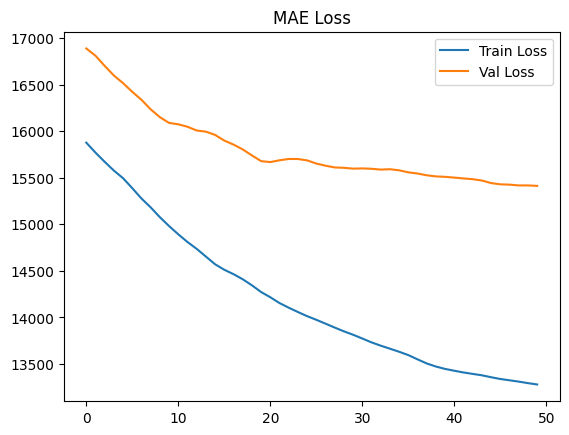

In [115]:
# Entrenamiento del modelo
epochs = 50000  # Ajusta según tu caso
log_interval = 500

for epoch in range(epochs):
    # --- TRAIN PHASE ---
    model.train()
    optimizer.zero_grad()

    # 1) Forward (asegúrate de pasar las 2 entradas: X, job_title)
    predictions = model(X_train_tensor)
    
    # 2) Cálculo de la pérdida en entrenamiento
    train_loss = criterion(predictions, y_train_tensor)

    # 3) Backprop
    train_loss.backward()

    # 4) Actualización de parámetros
    optimizer.step()
    
    # --- VALIDATION PHASE (cada X iteraciones) ---
    if (epoch + 1) % log_interval == 0:
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_val_tensor)
            val_loss = criterion(val_predictions, y_val_tensor)

        # Almaceno valores de pérdida para gráficas
        train_loss_values.append(train_loss.item())
        val_loss_values.append(val_loss.item())

        # Mostrar progreso
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss.item():.4f} "
              f"Val Loss: {val_loss.item():.4f}")

        # (Opcional) Gráfica de pérdidas en tiempo real
        fig = plt.figure()
        plt.plot(train_loss_values[-50:], label='Train Loss')
        plt.plot(val_loss_values[-50:], label='Val Loss')
        plt.legend()
        plt.title("MAE Loss")
        plt.show()
        clear_output(wait=True)

## Evaluación

In [119]:
# Evaluación del modelo
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    test_loss = criterion(y_pred_test, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 16423.2383


In [117]:
y_pred_test

tensor([[148291.8906],
        [ 78962.4609],
        [ 61486.2969],
        [116058.3906],
        [131429.5312],
        [167759.9844],
        [138590.3438],
        [ 83379.4609],
        [ 49306.2891],
        [ 38936.0938],
        [ 34773.1797],
        [ 82140.3750],
        [177630.1875],
        [169103.5312],
        [131379.6250],
        [181163.9062],
        [136558.9531],
        [ 30940.0762],
        [ 71525.5234],
        [174288.2656],
        [106368.6875],
        [ 40901.9297],
        [155771.3281],
        [ 60799.1953],
        [125717.7734],
        [157087.4062],
        [121564.5469],
        [ 42464.6094],
        [101150.7422],
        [168590.8438],
        [ 75610.6641],
        [ 30905.6777],
        [ 91496.2188],
        [ 94770.6562],
        [136636.2031],
        [ 86080.9219],
        [ 29384.8887],
        [117579.4062],
        [ 40149.1875],
        [158443.4062],
        [ 33751.1797],
        [ 80200.8984],
        [ 51705.2656],
        [15

In [118]:
import torch

# Evaluación del modelo
model.eval()
with torch.no_grad():

    manual_input = [[32.0,175,5.0,0,1,0,0,1,0,0,0,0,0]]
    manual_input_scaled = scaler.transform(manual_input)

    # Crear un tensor con los valores de entrada manualmente
    manual_input = torch.tensor(manual_input_scaled, dtype=torch.float32)
    y_pred_test = model(manual_input)
    print(y_pred_test)

tensor([[124634.8516]])


c:\Users\pablo\anaconda3\envs\pythorch\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
